# Factors influencing the type of a car crash using Montgomery County Crash Data
*by Jesus A. Bernal Lopez and Julia Werner*

Car crashes are to be avoided at all costs, but if it comes to a crash, it is more desirable that it is a property damage crash than an injury crash or even a fatal crash. In order to prevent injury crashes and fatal crashes, the goal of this report is to identify factors which make a crash more likely to be an injury crash, using the Automated Crash Reporting System (ACRS) Report Type as an identifier.

# The Data

The data used are all traffic collisions on county and local roadways within Montgomery County, collected from the Automated Crash Reporting System (ACRS) of the Maryland State Police and reported by the Montgomery County Police, Gaithersburg Police, Rockville Police and the Maryland-National Capital Park Police. Collision data and involved drivers were recorded. The data collection was created on September 19, 2017 and last updated on October 17, 2019. The data is updated weekly and owned by the MCG ESB Service. 

The data consists of 101k rows and 43 columns. 39 of these columns are categorical and 4 columns are numeric. The numeric columns are speed limit of type int64, vehicle year of type int64, latitude and longitude of type float64. The data focuses on vehicles, persons involved, roads involved and the damage extent and severity of the crash.

Flaws of the data include some of the information not being verified by any further investigation and the information possibly including mechanical or human error. The data may include both verified and unverified collision data. The collision data may be changed based on further investigation.

## Data Preprocessing

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import zscore
import seaborn as sns
sns.set()
rcParams['figure.figsize'] = 12,8
sns.set_context('talk')

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/CruddyShad0w/CST-383-CrashData/master/Crash_Reporting_-_Drivers_Data.csv',low_memory=False)

df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'])
df.set_index('Crash Date/Time', inplace=True)
df.sort_index(inplace=True)

df['Off-Road Description'].isna().mean()

0.9088149538682749

## Data Cleaning

The columns 'Off-Road Description', 'Municipality', and 'Circumstance', were dropped because too many data were missing to make accurate conclusions. The columns 'Driverless Vehicle', 'Report Number', and 'Local Case Number' were dropped, because they had no use for the analysis regarding the report type. <br>
The rows with Speed Limit equal to zero were dropped after filling a few of the missing values in the Speed Limit with the median for all accidents with the same Cross Street Name. <br>
Rows with more than 30% missing values, invalid vehicle year and 'Unknown' values for Route type where not useful for the analysis and were therefore dropped.
The amount of data regarding fatal crashes was too small to show significant results, which is why we decided to drop it.

In [0]:
clean_df = df.drop(columns=['Off-Road Description', 'Municipality', 'Circumstance', 'Driverless Vehicle', 'Report Number', 'Local Case Number'])

clean_df['Related Non-Motorist'].fillna("NONE",inplace=True)

cross_street_name_speed_limit_median = clean_df.groupby('Cross-Street Name')['Speed Limit'].median()
clean_df['Speed Limit'] = [row['Speed Limit'] if row['Speed Limit'] != 0 else cross_street_name_speed_limit_median[row['Cross-Street Name']] if type(row['Cross-Street Name']) != float else 0 for index, row in clean_df.iterrows()]
clean_df = clean_df[clean_df['Speed Limit'] != 0]

clean_df = clean_df[clean_df['ACRS Report Type'] != 'Fatal Crash']

clean_df = clean_df[clean_df.isna().mean(axis=1) <= 0.3]
clean_df = clean_df[clean_df['Vehicle Make'].notna()]

clean_df=clean_df[(clean_df['Vehicle Year']>=1800)&(clean_df['Vehicle Year']<=2019)]

clean_df = clean_df[clean_df['Route Type']!='Unknown']

clean_df['Vehicle Make'].replace('TOYT','TOYOTA',inplace=True)
clean_df['Vehicle Make'].replace('HOND','HONDA',inplace=True)
clean_df['Vehicle Make'].replace('NISS','NISSAN',inplace=True)


# Which factors influence the result of the crash?

### During what month do most crashes occur?

We wanted to find out if it is true that during the summer months more car crashes (both property damage and injury) because more families go on vacations because their children are out of school. However, we found two interesting peaks for the Injury Crashes in the months of May and September. While in the Property Damage Crash graph we found an unusually low amount of crashes for the month of July in 2015.

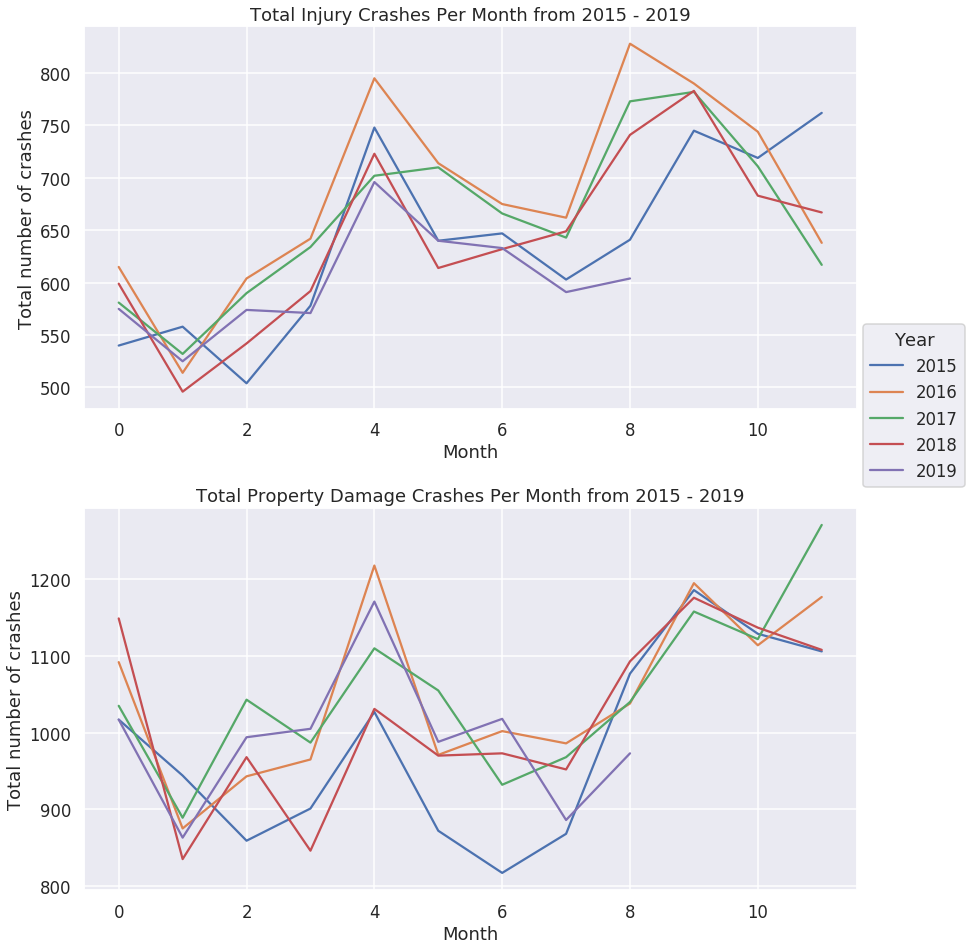

In [0]:
clean_df['Month'] = clean_df.index.month
clean_df['Year'] = clean_df.index.year

years = clean_df.groupby('Year')

years = list()
injury_crash_per_year = list()
property_damage_crash_per_year = list()
total_crashes_per_year = list()

for year in range(2015, 2020):
  years.append(clean_df[clean_df['Year'] == year])

for year in years:
  injury_crash_per_year.append(year.groupby('Month').apply(lambda x: (x['ACRS Report Type'] == 'Injury Crash').sum()))
  property_damage_crash_per_year.append(year.groupby('Month').apply(lambda x: (x['ACRS Report Type'] == 'Property Damage Crash').sum()))
  total_crashes_per_year.append(year.groupby('Month').apply(lambda x: (x['ACRS Report Type'].shape[0])))


fig, ax = plt.subplots(2)
fig.tight_layout()
plots_injury = list()
plots_property = list()

for injury_crash, property_crash in zip(injury_crash_per_year, property_damage_crash_per_year):
  if len(injury_crash) == 10 or len(property_crash) == 10:
    plots_injury.append(ax[0].plot(np.arange(len(injury_crash[:-1])), injury_crash[:-1]))
    plots_property.append(ax[1].plot(np.arange(len(property_crash[:-1])), property_crash[:-1]))
  else:
    plots_injury.append(ax[0].plot(np.arange(len(injury_crash)), injury_crash))
    plots_property.append(ax[1].plot(np.arange(len(property_crash)), property_crash))

plt.subplots_adjust(bottom=1.0, top=2.5)

ax[0].set_title('Total Injury Crashes Per Month from 2015 - 2019')
ax[1].set_title('Total Property Damage Crashes Per Month from 2015 - 2019')

ax[0].set_ylabel('Total number of crashes')
ax[1].set_ylabel('Total number of crashes')

ax[0].set_xlabel('Month')
ax[1].set_xlabel('Month')

plt.legend((plots_injury[0][0], plots_injury[1][0], plots_injury[2][0], plots_injury[3][0], plots_injury[4][0]), ('2015', '2016', '2017', '2018', '2019'), title='Year', bbox_to_anchor=(1.15, 1.5));

### Do more injuries occur when the speed limit is higher?

We had a theory that if you were involved in an accident the odds of an injury occurring on the crash would increase as the speed limit increased. The graph below shows our theory was correct but not as drastic as we initially believed. The graph shows starting with speed limit of 30 and above the injury percentage is higher than of property damage.

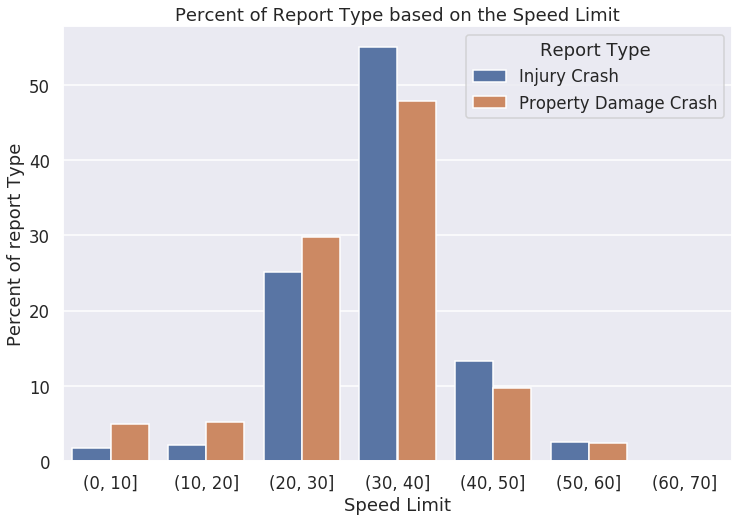

In [0]:
speed_limit_bins = np.arange(0, 71, 10)

clean_df['Speed Limit Bin'] = pd.cut(x=clean_df['Speed Limit'], bins=speed_limit_bins)

occupation_counts = (clean_df.groupby(['ACRS Report Type'])['Speed Limit Bin']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(by='Speed Limit Bin', ascending=True))


sns.barplot(x="Speed Limit Bin", y="percentage", hue="ACRS Report Type", data=occupation_counts)

plt.legend(title='Report Type')

plt.xlabel('Speed Limit')
plt.ylabel('Percent of report Type')

plt.title('Percent of Report Type based on the Speed Limit');

### Does injury risk increase when under the influence?

We wanted to know if being under the influence would increase the odds of an injury occurring in an accident. We thought that if you are under the influence the accident would be more severe because you would not be fully aware of what is going on around you. By looking at the graph below, it shows that being under the influence of any kind of substance does slightly increase the odds of a crash ending in an injury.

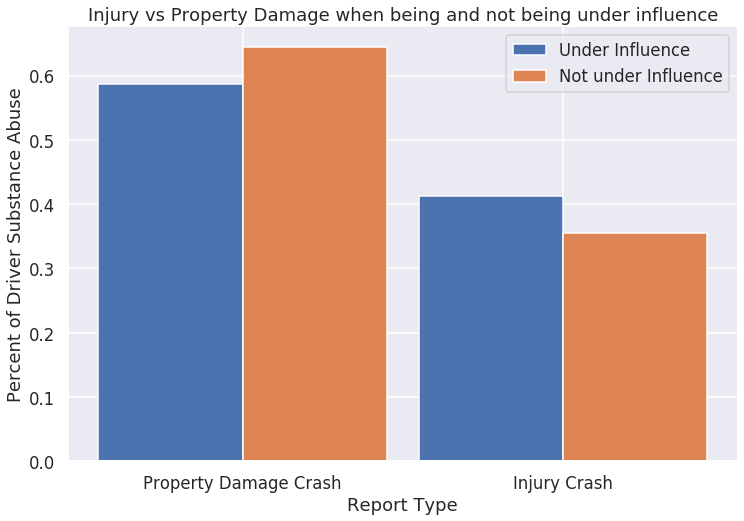

In [0]:
under_influence = clean_df[(clean_df['Driver Substance Abuse'] == 'NONE DETECTED')&(clean_df['ACRS Report Type']!='Fatal Crash')]['ACRS Report Type'].value_counts()
not_under_influence = clean_df[(clean_df['Driver Substance Abuse'] != 'UNKNOWN') & (clean_df['Driver Substance Abuse'] != 'NONE DETECTED') & (clean_df['Driver Substance Abuse'] != 'OTHER')&(clean_df['ACRS Report Type']!='Fatal Crash')]['ACRS Report Type'].value_counts()
all_report_types = clean_df['ACRS Report Type'].value_counts()

width = 0.45

fig, ax = plt.subplots()
ind = np.arange(len(under_influence))

p1 = ax.bar(ind, height=under_influence.values / under_influence.values.sum(), width=width)
p2 = ax.bar(ind + width, height=not_under_influence.values / not_under_influence.values.sum(), width=width)

ax.set_title('Injury vs Property Damage when being and not being under influence')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(under_influence.index)

ax.set_ylabel('Percent of Driver Substance Abuse')
ax.set_xlabel('Report Type')

ax.legend((p1[0], p2[0]), ('Under Influence', 'Not under Influence'));

### Motorcycle accident occurences in detail

When examining the 15 most frequently occurring body types, we found motorcycles were the only vehicles that had more injury crashes than property damage crashes. A detailed percentage diagram shows that more than 80% of the crashes result in an injury crash for motorcycles, while less than 20% result in a property damage crash. Therefore, it can be concluded that persons driving motorcycles when getting into an accident will more likely get injured.

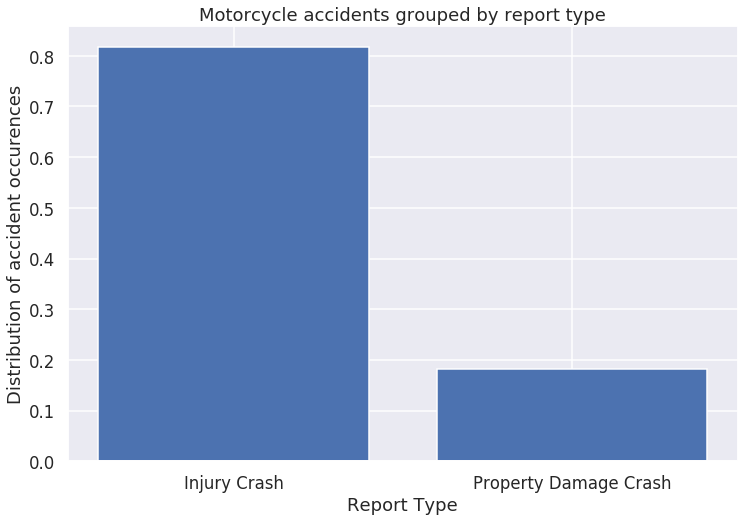

In [0]:
motorc_incidents=clean_df[clean_df['Vehicle Body Type']=='MOTORCYCLE']['ACRS Report Type']
ax=motorc_incidents.value_counts()
ax2=ax.values/ax.values.sum()

plt.bar(ax.index,ax2)

plt.title('Motorcycle accidents grouped by report type')
plt.xlabel('Report Type')
plt.ylabel('Distribution of accident occurences');

### Does the driver at fault get more damage from the crash, or the driver not being at fault?

If the driver at fault takes more damage in the crash, it is a motivation for drivers to drive carefully. Therefore, the purpose of the plot was to find out if the driver being at fault would be affected by the report type. The plot shows that the drivers are more likely at fault for property damage crashes, where the driver is at fault for about 55% of the accidents, while the driver is not at fault for 45% of the accidents. For injury crashes, the driver is at fault for the accident approximately 51% of the times, while the driver was not at fault for 41% of the injury crashes. This shows that property crashes are 10% more often caused by the driver, while injury crashes are about equally likely to happen to the driver at fault and to a driver not at fault.

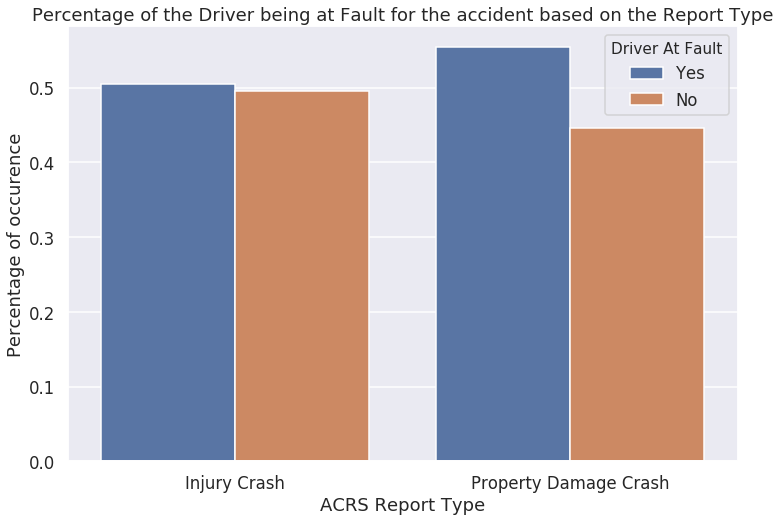

In [0]:
drivers_df=clean_df[(clean_df['Driver At Fault']!='Unknown')&(clean_df['ACRS Report Type']!='Fatal Crash')]
drivers_df=drivers_df.groupby(['ACRS Report Type'])['Driver At Fault'].value_counts(normalize=True).rename('Percent Values').reset_index().sort_values(by='ACRS Report Type')
drivers_plot=sns.barplot(x='ACRS Report Type',y="Percent Values",hue='Driver At Fault',data=drivers_df)
drivers_plot.set_title('Percentage of the Driver being at Fault for the accident based on the Report Type')
drivers_plot.set_ylabel('Percentage of occurence');

### How are the 3 most frequent vehicles to have accidents affected by the weather?

Focusing on the three most frequent vehicle makes, the plot focuses on crashes occurring at less frequent weather related to the report type. The purpose of the plot is to find out, which less frequently occurring weathers the three most frequent vehicle makes are most sensitive to and whether the report type is affected by these weather patterns for those particular vehicle makes. The plot shows that Ford has a lot more Property Damage Crashes during snow than the other vehicles, while Honda has more Property Damage Crashes during fog. Toyota has the most injury crashes during snow and fog, while Honda has the least crashes and Ford and Honda have the same amount of injury crashes during fog. Honda has about the same amount of sleet crashes, while Ford has the most Property Damage Crashes during sleet and Honda has the most injury crashes during sleet. To get more detailed information about the amount of crashes, more data would be needed.

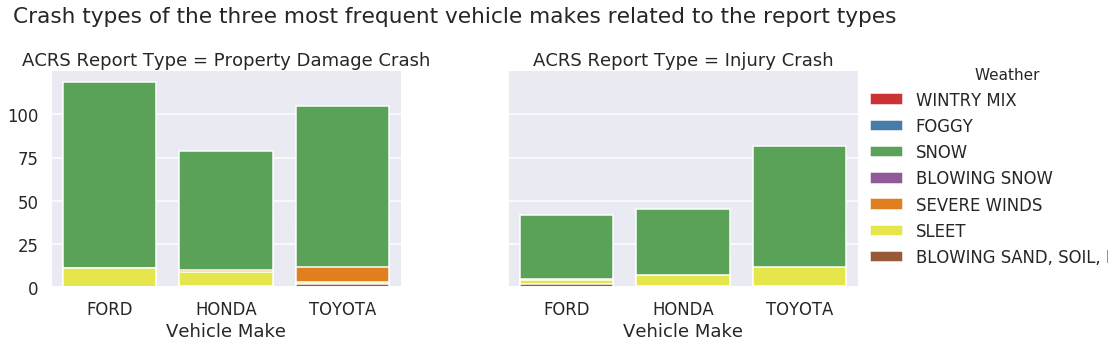

In [0]:
top_v=clean_df[((clean_df['Vehicle Make']=="TOYOTA")|(clean_df['Vehicle Make']=="HONDA")|(clean_df['Vehicle Make']=="FORD"))&((clean_df['Weather']!="UNKNOWN"))&((clean_df['Weather']!="CLEAR"))&((clean_df['Weather']!="RAINING"))&((clean_df['Weather']!="CLOUDY"))&((clean_df['Weather']!="OTHER"))]
top_g=sns.FacetGrid(data=top_v,col='ACRS Report Type',hue='Weather',palette='Set1',height=5,aspect=1).map(sns.countplot,'Vehicle Make',order=top_v['Vehicle Make'].unique()).add_legend(bbox_to_anchor=(1.15, 0.5))
top_g.fig.suptitle('Crash types of the three most frequent vehicle makes related to the report types')

plt.subplots_adjust(left=0.1, right= 0.9, top=0.8);

### How severe are the injuries caused by injury crashes?

The plot shows the distribution of the injury severities for injury crashes only, since there are no injury crashes in property damage crashes. It was surprising that most injuries were no apparent injuries. A reason might be the labeling of the injury crash. If only one person needs to be injured for a crash to be an injury crash, the plot might indicate that in most injury crashes, not all persons get injured.

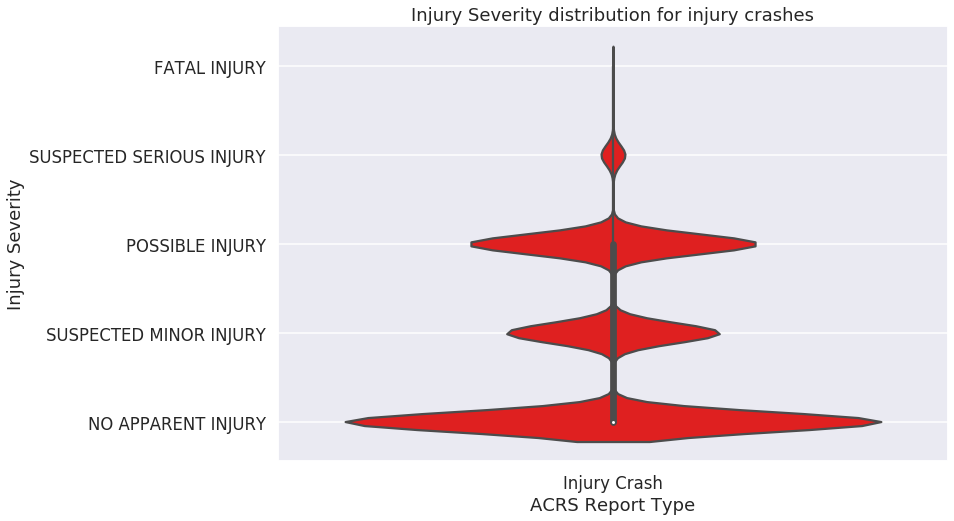

In [0]:
clean_df['Injury Severity Numeric']=pd.factorize(clean_df['Injury Severity'])[0]
in_df=clean_df[clean_df['ACRS Report Type']=='Injury Crash']
in_plot=sns.violinplot(x='ACRS Report Type',y='Injury Severity Numeric',data=in_df,color='red')
in_plot.set_yticks([0,1,2,3,4])
in_plot.set_yticklabels(in_df['Injury Severity'].unique())
in_plot.set_ylabel('Injury Severity')
in_plot.set_title('Injury Severity distribution for injury crashes');

# Conclusion

The data showed that the number of crashes peaked in April and September in Montgomery County over the years of 2015-2019, while the rate of crashes is the lowest in February.
Most crashes occurred between 30-40 miles per hour, which is expected, as it is the most common speed limit. An accident above 30 miles per hour is more likely to be an injury crash rather than a property crash, which concludes that the injury risk in a car crash happening at a speed of more than 30 miles per hour is significantly higher. Being under the influence of any drugs slightly increased the risk of being in an injury crash rather than a property damage crash. The dataset also showed motorcycles as an outlier between the 15 most frequently used vehicle body types, where crashes ended in injury crashes more often than in property crashes. The lack of walls around the driver might be a factor responsible for the high amount of injury crashes. The driver fault is not a largely significant factor for the report type, but the driver at fault is slightly more likely to be in a property car crash rather than a driver not being at fault. Regarding the top three most occurring vehicles, Toyota is relatively unsafe in more rarely occurring weather conditions like snow, fog or sleet, since it has a relatively high amount of property crashes and about double the amount of injury crashes compared to Ford and Honda. In injury crashes, most people are labeled as not injured, which leads to the assumption that a crash is labeled an injury crash, when at least one person is injured. In conclusion, more people are part of an injury crash than the person injured, but most of them are not injured. When a person is injured, the most common injury severity is a possible injury.




